In [96]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from os import listdir
import fnmatch

import sys
sys.path.append('..')
from variationanalysis import score, statTest

from scipy.stats import ttest_1samp

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Select strain-specific regions

In [110]:
file = './data/C57Bl6_PWK_2condition_merged.txt'
merge_df = pd.read_csv(file, sep='\t', index_col=0)
merge_df.index.name = None
merge_df = merge_df.drop(merge_df.index[np.argwhere(merge_df.iloc[:,0] == 'chrX').flatten()])

In [117]:
null_bools = merge_df.iloc[:,-4:].notnull()
s1_spec_bools = np.all([null_bools.sum(axis=1) == 1, null_bools.iloc[:,0]], axis=0)
s2_spec_bools = np.all([null_bools.sum(axis=1) == 1, null_bools.iloc[:,2]], axis=0)
spec1_df = merge_df.loc[s1_spec_bools].sort_values(by=merge_df.columns[5])
spec2_df = merge_df.loc[s2_spec_bools].sort_values(by=merge_df.columns[5])
spec1_df.iloc[:,:6].to_csv(file.replace('.txt','_C57_spec.txt'), sep='\t')
spec2_df.iloc[:,:6].to_csv(file.replace('.txt','_PWK_spec.txt'), sep='\t')
print(spec1_df.shape)
print(spec2_df.shape)

(22607, 11)
(1535, 11)


In [112]:
%%bash
cd ./data/
genome_dir=/home/zes017/genomes/
file1=C57Bl6_PWK_2condition_merged_C57_spec.txt
file2=C57Bl6_PWK_2condition_merged_PWK_spec.txt
out1=$(echo $file1 | sed 's/.txt/.fa/g')
out2=$(echo $file2 | sed 's/.txt/.fa/g')
perl /home/zes017/extract_seq_from_peakfiles.pl -ind C57 PWK -file $file1 -data_dir $genome_dir -output $out1 &
perl /home/zes017/extract_seq_from_peakfiles.pl -ind PWK C57 -file $file2 -data_dir $genome_dir -output $out2 &

Saving peaks
This it is: C57Bl6_PWK_2condition_merged_C57_spec.txt
Saving peaks
This it is: C57Bl6_PWK_2condition_merged_PWK_spec.txt
Loading shift vectors
Loading shift vectors
Can't open /home/zes017/genomes//C57/chr_allele_1.fa
Exclude chromosome  allele 1 from analysis
Can't open /home/zes017/genomes//PWK/chr_allele_1.fa
Exclude chromosome  allele 1 from analysis
Skip peaks for chromosome Y allele 1 in get_seq_for_peaks
Skip peaks for chromosome Y allele 1 in get_seq_for_peaks


# Compute score difference

In [144]:
%%bash
cd ./data/
for seq_file in *PWK_spec.fa; do
#     echo $seq_file
    python ../bin/compute_score_diff.py $seq_file -p 8 -D -R &>/dev/null &
done

# Read score difference

In [6]:
diff_score_files = ['./data/'+f for f in fnmatch.filter(listdir('./data/'), '*_motifScoresDiff.tsv')]
all_score_diff, motifs = statTest.merge_score_diff(diff_score_files, cut_percent=0)

Merging files:
-- ./data/C57Bl6_PWK_2condition_merged_C57_spec_motifScoresDiff.tsv
-- ./data/C57Bl6_PWK_2condition_merged_PWK_spec_motifScoresDiff.tsv
Filtering out 0 % outliers


# T test

In [105]:
statTest.Ttest(all_score_diff, motifs, save=True, prefix='./data/C57Bl6_PWK_2condition_merged')

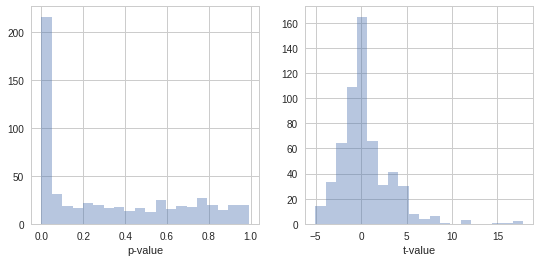

In [15]:
stats_df = pd.read_csv('./data/C57Bl6_PWK_2condition_merged_Ttest_stats.tsv', sep='\t', index_col=0)
p_values = stats_df['p-value']
t_values = stats_df['t-value']

plt.figure(figsize=(9,4))
sns.set(style='whitegrid')
plt.subplot(1,2,1)
sns.distplot(p_values, kde=False, bins=20)
plt.xlabel('p-value')
plt.subplot(1,2,2)
sns.distplot(t_values, kde=False, bins=20)
plt.xlabel('t-value')

# Heatmap of p-values

In [28]:
%%bash
cd /data/mm10/BMDM/RNA/
analyzeRepeats.pl rna mm10 -count exons -condenseGenes -tpm -d \
BALB_BMDM_polyA_RNA_notx_BC_15_10_20 BALB_BMDM_polyA_RNA_notx_BC_16_03_08 \
BALB_BMDM_polyA_RNA_KLA_1h_BC_15_10_20 BALB_BMDM_polyA_RNA_KLA_1h_BC_16_03_08 \
C57_BMDM_polyA_RNA_notx_BC_16_03_08 C57_BMDM_polyA_RNA_notx_BC_15_10_20 \
C57_BMDM_polyA_RNA_KLA_1h_BC_16_03_08 C57_BMDM_polyA_RNA_KLA_1h_BC_15_10_20 \
NOD_BMDM_polyA_RNA_notx_EW_rep2_combined_17_03_07_and_17_04_03 NOD_BMDM_polyA_RNA_notx_EW_rep3_combined_17_03_07_and_17_04_03 \
NOD_BMDM_polyA_RNA_KLA_1h_EW_rep3_combined_17_03_07_and_17_04_03 NOD_BMDM_polyA_RNA_KLA_1h_EW_rep2_combined_17_03_07_and_17_04_03 \
PWK_BMDM_polyA_RNA_notx_BC_16_03_08 PWK_BMDM_polyA_RNA_notx_BC_15_10_20 \
PWK_BMDM_polyA_RNA_KLA_1h_BC_16_03_08 PWK_BMDM_polyA_RNA_KLA_1h_BC_15_10_20 \
SPRET_BMDM_polyA_RNA_notx_BC_16_03_08 SPRET_BMDM_polyA_RNA_notx_BC_15_10_20 \
SPRET_BMDM_polyA_RNA_KLA_1h_BC_16_03_08 SPRET_BMDM_polyA_RNA_KLA_1h_BC_15_10_20 > /home/zes017/IL4/KLA/KLA_RNA_tpm.tsv 2>/dev/null &

In [156]:
stats_files = ['./data/C57Bl6_PWK_2condition_merged_Ttest_stats.tsv']
sig_df, tpm_df = statTest.Filter(stats_files, sig_t=0.05, tpm_file='./data/IL4_RNA_tpm.tsv', exp_t=4)
sig_df.columns = np.arange(sig_df.shape[-1])
tpm_df.columns = np.arange(tpm_df.shape[-1])

Missing gene expression: ['ZNF740', 'MIX-A']


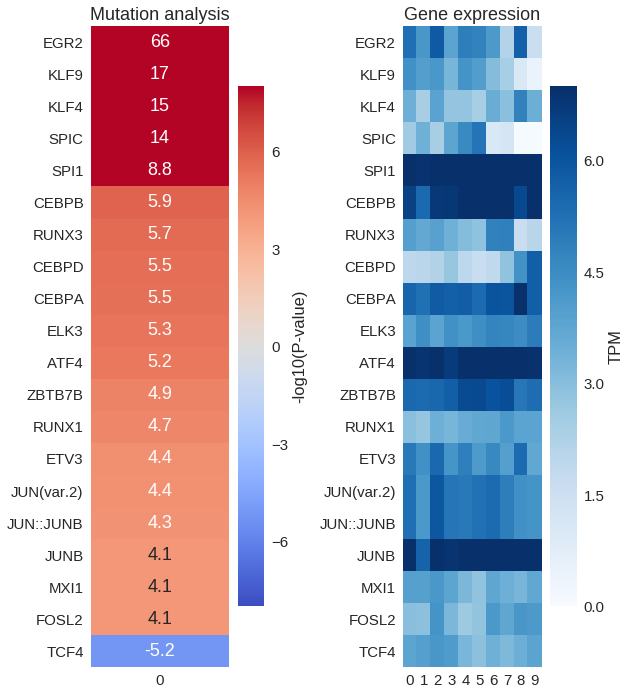

In [166]:
plt.figure(figsize=(sig_df.shape[1]*4+tpm_df.shape[1]*0.5, len(sig_df)*0.5))
sns.set(font_scale=1.5)

plt.subplot(1,2,1)
sns.heatmap(sig_df, cmap='coolwarm', vmin=-8, vmax=8, 
            annot=True, cbar_kws={'label': '-log10(P-value)'})
plt.title('Mutation analysis')

plt.subplot(1,2,2)
sns.heatmap(tpm_df, cmap='Blues', vmin=0, vmax=7, cbar_kws={'label': 'TPM'})
plt.title('Gene expression')

plt.tight_layout()
plt.show()